In [7]:
import os
from pathlib import Path
import numpy as np
import pandas as pd
import mne
import time
from matplotlib import pyplot as plt
import torch

# Visualising the metadata of a raw edf file

In [ ]:
file_path = Path(os.getcwd()).parent.parent / 'data/eegdata' / 'Subject12_1.edf'

raw = mne.io.read_raw_edf(file_path, preload=True, verbose=False)

mne.time_frequency.psd_array_welch

In [5]:
raw

<RawEDF | Subject12_1.edf, 21 x 91000 (182.0 s), ~14.6 MiB, data loaded>

In [6]:
raw.times

array([0.00000e+00, 2.00000e-03, 4.00000e-03, ..., 1.81994e+02,
       1.81996e+02, 1.81998e+02], shape=(91000,))

In [14]:
BRAINWAVE_BANDS = {
    'delta': (0.5, 4),    # Sleep, deep relaxation
    'theta': (4, 8),      # Drowsiness, meditation, creativity
    'alpha': (8, 13),     # Relaxation, calmness, reflection
    'beta': (13, 30),     # Active thinking, focus, alertness
    'gamma': (30, 45)     # Higher cognitive processing, perception
}

def plot_psd_comparison(baseline_raw, arithmetic_raw, subject_id=None, bands=BRAINWAVE_BANDS, save_path=None):
    """
    Compute and plot PSD comparison between baseline and arithmetic tasks
    for a single subject.
    
    Parameters
    ----------
    baseline_raw : mne.io.Raw
        Preprocessed baseline EEG data
    arithmetic_raw : mne.io.Raw
        Preprocessed arithmetic EEG data
    subject_id : str or int
        Subject identifier (for title)
    bands : dict
        Frequency bands of interest (label -> (low, high))
    save_path : str or Path, optional
        If provided, saves the figure instead of showing
    """
    # ---- 1️⃣ Compute PSD for each condition ----
    psd_base, freqs = mne.time_frequency.psd_array_welch(
        baseline_raw.get_data(), sfreq=500.0, fmin=0.5, fmax=45, n_fft=1024, verbose=False
    )
    psd_arith, _ = mne.time_frequency.psd_array_welch(
        arithmetic_raw.get_data(), sfreq=500.0, fmin=0.5, fmax=45, n_fft=1024, verbose=False
    )

    # Average across all channels
    psd_base_mean = psd_base.mean(axis=0)
    psd_arith_mean = psd_arith.mean(axis=0)

    # ---- 2️⃣ Compute band power summary ----
    band_powers = []
    for band_name, (fmin, fmax) in bands.items():
        idx_band = np.logical_and(freqs >= fmin, freqs <= fmax)
        mean_base = np.mean(psd_base_mean[idx_band])
        mean_arith = np.mean(psd_arith_mean[idx_band])
        band_powers.append((band_name, mean_base, mean_arith))

    # ---- 3️⃣ Plot full PSD curves ----
    plt.figure(figsize=(10, 5))
    plt.plot(freqs, psd_base_mean, label='Baseline', color='blue', alpha=0.7)
    plt.plot(freqs, psd_arith_mean, label='Arithmetic', color='red', alpha=0.7)
    plt.xlabel('Frequency (Hz)')
    plt.ylabel('Power Spectral Density (uV²/Hz)')
    plt.title(f"Subject {subject_id} - PSD Comparison (Baseline vs Arithmetic)")
    plt.legend()
    plt.grid(True, alpha=0.3)

    # Highlight band regions
    for band_name, (fmin, fmax) in bands.items():
        plt.axvspan(fmin, fmax, color='gray', alpha=0.1)
        plt.text((fmin+fmax)/2, plt.ylim()[1]*0.8, band_name,
                 ha='center', va='center', fontsize=9, alpha=0.7)

    if save_path:
        plt.savefig(save_path, dpi=200, bbox_inches='tight')
        plt.close()
    else:
        plt.show()

    # ---- 4️⃣ Optional: print summary ----
    print(f"\nSubject {subject_id} - Mean Band Power Summary:")
    for b, base, arith in band_powers:
        diff = arith - base
        print(f"  {b.capitalize():<6}: Baseline={base:.4f}, Arithmetic={arith:.4f}, Δ={diff:+.4f}")

    return band_powers

In [ ]:
def plot_mean_psd_comparison_all_subjects(baseline_list, arithmetic_list, bands=BRAINWAVE_BANDS, save_path=None):
    """
    Compute and plot mean PSD comparison (Baseline vs Arithmetic) averaged across all subjects.

    Parameters
    --
    baseline_list : list of mne.io.Raw
        List of preprocessed baseline data (one per subject)
    arithmetic_list : list of mne.io.Raw
        List of preprocessed arithmetic data (one per subject)
    bands : dict
        Dictionary of brainwave bands to annotate
    save_path : str or Path, optional
        If provided, saves the plot to this path
    """
    assert len(baseline_list) == len(arithmetic_list), "Baseline and Arithmetic lists must have same length"
    n_subjects = len(baseline_list)
    print(f"Computing mean PSD over {n_subjects} subjects...")

    #  Compute PSDs for each subject 
    all_psd_base = []
    all_psd_arith = []

    for subj_idx, (baseline_raw, arithmetic_raw) in enumerate(zip(baseline_list, arithmetic_list)):
        psd_base, freqs = mne.time_frequency.psd_array_welch(
            baseline_raw.get_data(), sfreq=500.0, fmin=0.5, fmax=45, n_fft=1024, verbose=False
        )
        psd_arith, _ = mne.time_frequency.psd_array_welch(
            arithmetic_raw.get_data(), sfreq=500.0, fmin=0.5, fmax=45, n_fft=1024, verbose=False
        )

        # Mean across channels
        psd_base_mean = psd_base.mean(axis=0)
        psd_arith_mean = psd_arith.mean(axis=0)

        all_psd_base.append(psd_base_mean)
        all_psd_arith.append(psd_arith_mean)

    #  Convert to arrays and average across subjects 
    psd_base_all = np.vstack(all_psd_base)
    psd_arith_all = np.vstack(all_psd_arith)

    psd_base_mean = psd_base_all.mean(axis=0)
    psd_arith_mean = psd_arith_all.mean(axis=0)
    psd_base_std = psd_base_all.std(axis=0)
    psd_arith_std = psd_arith_all.std(axis=0)

    # Compute band power summaries across subjects 
    band_summary = []
    for band_name, (fmin, fmax) in bands.items():
        idx_band = np.logical_and(freqs >= fmin, freqs <= fmax)
        mean_base = np.mean(psd_base_all[:, idx_band], axis=1).mean()
        mean_arith = np.mean(psd_arith_all[:, idx_band], axis=1).mean()
        diff = mean_arith - mean_base
        band_summary.append((band_name, mean_base, mean_arith, diff))

    # Plot grand mean PSDs 
    plt.figure(figsize=(10, 5))
    plt.plot(freqs, psd_base_mean, label='Baseline', color='blue', alpha=0.8)
    plt.fill_between(freqs, psd_base_mean - psd_base_std, psd_base_mean + psd_base_std, color='blue', alpha=0.2)

    plt.plot(freqs, psd_arith_mean, label='Arithmetic', color='red', alpha=0.8)
    plt.fill_between(freqs, psd_arith_mean - psd_arith_std, psd_arith_mean + psd_arith_std, color='red', alpha=0.2)

    plt.xlabel("Frequency (Hz)")
    plt.ylabel("Power Spectral Density (uV²/Hz)")
    plt.title("Mean PSD Comparison (All Subjects)\nBaseline vs Arithmetic")
    plt.legend()
    plt.grid(True, alpha=0.3)

    for band_name, (fmin, fmax) in bands.items():
        plt.axvspan(fmin, fmax, color='gray', alpha=0.1)
        plt.text((fmin + fmax)/2, plt.ylim()[1]*0.8, band_name,
                 ha='center', va='center', fontsize=9, alpha=0.7)

    if save_path:
        plt.savefig(save_path, dpi=200, bbox_inches='tight')
        plt.close()
    else:
        plt.show()

    #  Print band power summary 
    print("\nMean Band Power Summary (All Subjects):")
    for band, base, arith, diff in band_summary:
        print(f"  {band.capitalize():<6}: Baseline={base:.4f}, Arithmetic={arith:.4f}, Δ={diff:+.4f}")

    return band_summary

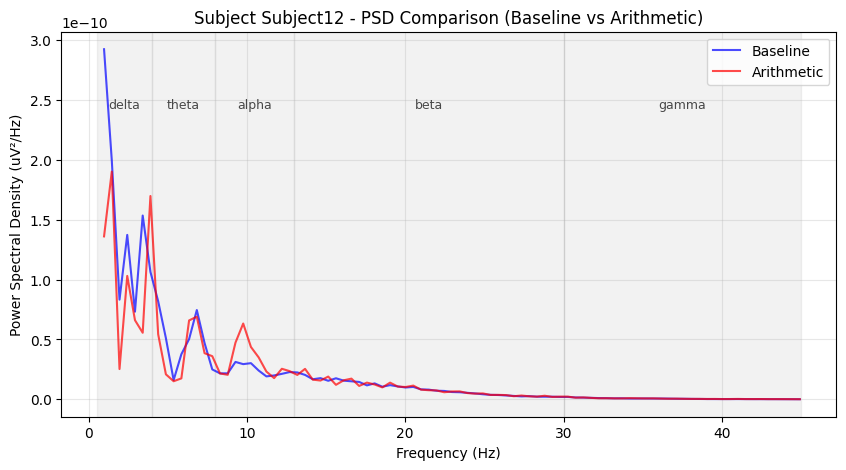


Subject Subject12 - Mean Band Power Summary:
  Delta : Baseline=0.0000, Arithmetic=0.0000, Δ=-0.0000
  Theta : Baseline=0.0000, Arithmetic=0.0000, Δ=-0.0000
  Alpha : Baseline=0.0000, Arithmetic=0.0000, Δ=+0.0000
  Beta  : Baseline=0.0000, Arithmetic=0.0000, Δ=+0.0000
  Gamma : Baseline=0.0000, Arithmetic=0.0000, Δ=+0.0000


In [15]:
file_path = Path(os.getcwd()).parent.parent / 'data/eegdata' / 'Subject12_1.edf'

baseline_raw = mne.io.read_raw_edf(file_path, preload=True, verbose=False)

file_path_2= Path(os.getcwd()).parent.parent / 'data/eegdata' / 'Subject12_2.edf'

arithmetic_raw = mne.io.read_raw_edf(file_path_2, preload=True, verbose=False)


pwr = plot_psd_comparison(baseline_raw, arithmetic_raw, 'Subject12')

In [16]:
file_path = Path(os.getcwd()).parent.parent / 'data/eegdata'
eeg_filepath_object = file_path.glob('*.edf')
eeg_files_paths = [i for i in eeg_filepath_object]

# read raw eeg files, preprocess them and save the resulting mne obj to a dictionary

baseline_list, arithmetic_list, = [], []

start = time.time()
for file in eeg_files_paths:
    
    raw = mne.io.read_raw_edf(file, preload=True, verbose=False)

    if file.stem.split('_')[1]=='1':
        baseline_list.append(raw.copy())
        print(f'{file.stem} extracted to baseline list!')
    else:
        arithmetic_list.append(raw.copy())
        print(f'{file.stem} extracted to arithmetic list!')

end = time.time()

print(f'time taken: {end-start}')

Subject00_1 extracted to baseline list!
Subject00_2 extracted to arithmetic list!
Subject01_1 extracted to baseline list!
Subject01_2 extracted to arithmetic list!
Subject02_1 extracted to baseline list!
Subject02_2 extracted to arithmetic list!
Subject03_1 extracted to baseline list!
Subject03_2 extracted to arithmetic list!
Subject04_1 extracted to baseline list!
Subject04_2 extracted to arithmetic list!
Subject05_1 extracted to baseline list!
Subject05_2 extracted to arithmetic list!
Subject06_1 extracted to baseline list!
Subject06_2 extracted to arithmetic list!
Subject07_1 extracted to baseline list!
Subject07_2 extracted to arithmetic list!
Subject08_1 extracted to baseline list!
Subject08_2 extracted to arithmetic list!
Subject09_1 extracted to baseline list!
Subject09_2 extracted to arithmetic list!
Subject10_1 extracted to baseline list!
Subject10_2 extracted to arithmetic list!
Subject11_1 extracted to baseline list!
Subject11_2 extracted to arithmetic list!
Subject12_1 extr

Computing mean PSD over 36 subjects...


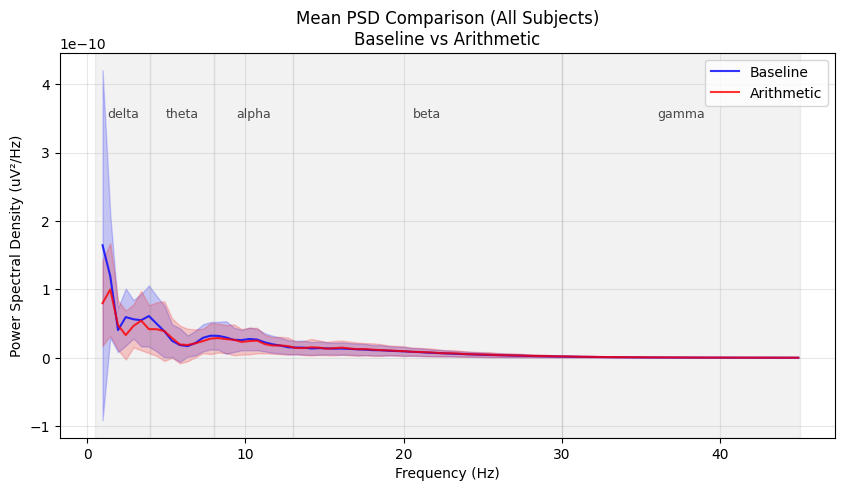


Mean Band Power Summary (All Subjects):
  Delta : Baseline=0.0000, Arithmetic=0.0000, Δ=-0.0000
  Theta : Baseline=0.0000, Arithmetic=0.0000, Δ=-0.0000
  Alpha : Baseline=0.0000, Arithmetic=0.0000, Δ=-0.0000
  Beta  : Baseline=0.0000, Arithmetic=0.0000, Δ=+0.0000
  Gamma : Baseline=0.0000, Arithmetic=0.0000, Δ=+0.0000


[('delta',
  np.float64(7.944155918839523e-11),
  np.float64(5.7641808399135575e-11),
  np.float64(-2.1799750789259657e-11)),
 ('theta',
  np.float64(2.9001864781513192e-11),
  np.float64(2.7691554065306273e-11),
  np.float64(-1.310310716206919e-12)),
 ('alpha',
  np.float64(2.435056593946053e-11),
  np.float64(2.2840432778550505e-11),
  np.float64(-1.5101331609100251e-12)),
 ('beta',
  np.float64(8.042432584293809e-12),
  np.float64(8.370458891308376e-12),
  np.float64(3.280263070145676e-13)),
 ('gamma',
  np.float64(5.842547133346572e-13),
  np.float64(6.727514462082785e-13),
  np.float64(8.849673287362125e-14))]

In [19]:
plot_mean_psd_comparison_all_subjects(baseline_list, arithmetic_list)

In [5]:
tmin = -0.2
tmax = 0.5 

sample_rate = int(raw.info['sfreq'])
event_spacing = sample_rate  # 1 event per second
n_samples = len(raw.times)

# Create events at regular intervals
events = np.array([
    [i, 0, 1] for i in range(0, n_samples, event_spacing)
    if i + int(tmax * sample_rate) < n_samples
])

In [6]:
epochs = mne.Epochs(raw, events, tmin=tmin, tmax=tmax, 
                                    baseline=(None, 0), preload=True, verbose=False)

In [7]:
epochs

<Epochs | 181 events (all good), -0.2 – 0.5 s (baseline -0.2 – 0 s), ~10.2 MiB, data loaded,
 '1': 181>

In [8]:
raw.describe()

<RawEDF | Subject12_1.edf, 21 x 91000 (182.0 s), ~14.6 MiB, data loaded>
ch  name       type  unit        min         Q1     median         Q3        max
 0  EEG Fp1    EEG   µV       -46.07      -6.13       0.00       6.02      46.27
 1  EEG Fp2    EEG   µV       -65.87      -6.89      -0.00       6.96      52.10
 2  EEG F3     EEG   µV       -49.85      -6.06      -0.11       6.08      48.56
 3  EEG F4     EEG   µV       -48.40      -7.26      -0.00       7.34      44.59
 4  EEG F7     EEG   µV       -50.03      -5.81      -0.11       5.76      43.29
 5  EEG F8     EEG   µV       -44.28      -7.21       0.18       7.24      45.38
 6  EEG T3     EEG   µV       -46.16      -5.63      -0.05       5.59      45.08
 7  EEG T4     EEG   µV      -162.64     -10.25      -0.19       9.69     139.24
 8  EEG C3     EEG   µV       -52.18      -6.31      -0.13       6.14      48.54
 9  EEG C4     EEG   µV       -58.03      -7.29      -0.24       7.12      54.64
10  EEG T5     EEG   µV       -48.77

In [9]:
raw.ch_names

['EEG Fp1',
 'EEG Fp2',
 'EEG F3',
 'EEG F4',
 'EEG F7',
 'EEG F8',
 'EEG T3',
 'EEG T4',
 'EEG C3',
 'EEG C4',
 'EEG T5',
 'EEG T6',
 'EEG P3',
 'EEG P4',
 'EEG O1',
 'EEG O2',
 'EEG Fz',
 'EEG Cz',
 'EEG Pz',
 'EEG A2-A1',
 'ECG ECG']

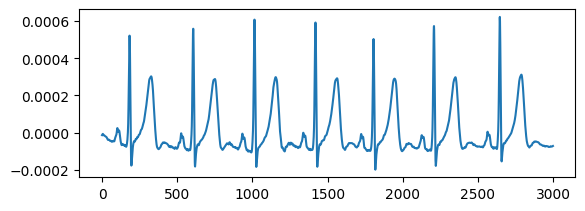

In [10]:
raw.ch_names
plotraw = raw.copy()
# plotraw.pick('EEG O1').plot()
# mne.preprocessing.find_ecg_events(raw)
plt.subplot(2, 1, 1)
plt.plot(plotraw.pick('ECG ECG').get_data([0])[0][:3000].flatten())
plt.show()

In [11]:
modraw = raw.copy()
modraw.set_channel_types({'ECG ECG': 'ecg'})

<RawEDF | Subject12_1.edf, 21 x 91000 (182.0 s), ~14.6 MiB, data loaded>

In [12]:
modraw.describe()

<RawEDF | Subject12_1.edf, 21 x 91000 (182.0 s), ~14.6 MiB, data loaded>
ch  name       type  unit        min         Q1     median         Q3        max
 0  EEG Fp1    EEG   µV       -46.07      -6.13       0.00       6.02      46.27
 1  EEG Fp2    EEG   µV       -65.87      -6.89      -0.00       6.96      52.10
 2  EEG F3     EEG   µV       -49.85      -6.06      -0.11       6.08      48.56
 3  EEG F4     EEG   µV       -48.40      -7.26      -0.00       7.34      44.59
 4  EEG F7     EEG   µV       -50.03      -5.81      -0.11       5.76      43.29
 5  EEG F8     EEG   µV       -44.28      -7.21       0.18       7.24      45.38
 6  EEG T3     EEG   µV       -46.16      -5.63      -0.05       5.59      45.08
 7  EEG T4     EEG   µV      -162.64     -10.25      -0.19       9.69     139.24
 8  EEG C3     EEG   µV       -52.18      -6.31      -0.13       6.14      48.54
 9  EEG C4     EEG   µV       -58.03      -7.29      -0.24       7.12      54.64
10  EEG T5     EEG   µV       -48.77

In [13]:
mne.preprocessing.find_ecg_events(modraw, ch_name='ECG ECG')

Using channel ECG ECG to identify heart beats.
Setting up band-pass filter from 5 - 35 Hz

FIR filter parameters
---------------------
Designing a two-pass forward and reverse, zero-phase, non-causal bandpass filter:
- Windowed frequency-domain design (firwin2) method
- Hann window
- Lower passband edge: 5.00
- Lower transition bandwidth: 0.50 Hz (-12 dB cutoff frequency: 4.75 Hz)
- Upper passband edge: 35.00 Hz
- Upper transition bandwidth: 0.50 Hz (-12 dB cutoff frequency: 35.25 Hz)
- Filter length: 5000 samples (10.000 s)

Number of ECG events detected : 208 (average pulse 68.57142857142857 / min.)


(array([[  183,     0,   999],
        [  606,     0,   999],
        [ 1014,     0,   999],
        [ 1420,     0,   999],
        [ 1806,     0,   999],
        [ 2208,     0,   999],
        [ 2646,     0,   999],
        [ 3129,     0,   999],
        [ 3611,     0,   999],
        [ 4035,     0,   999],
        [ 4470,     0,   999],
        [ 4905,     0,   999],
        [ 5344,     0,   999],
        [ 5764,     0,   999],
        [ 6172,     0,   999],
        [ 6623,     0,   999],
        [ 7110,     0,   999],
        [ 7604,     0,   999],
        [ 8053,     0,   999],
        [ 8471,     0,   999],
        [ 8899,     0,   999],
        [ 9314,     0,   999],
        [ 9699,     0,   999],
        [10059,     0,   999],
        [10432,     0,   999],
        [10846,     0,   999],
        [11305,     0,   999],
        [11754,     0,   999],
        [12217,     0,   999],
        [12724,     0,   999],
        [13230,     0,   999],
        [13710,     0,   999],
        

# Applying some preprocessing

In [14]:
ica = mne.preprocessing.ICA(
    n_components=15,
    random_state=42,
    method='fastica'
)

# Fit ICA on the data
ica.fit(modraw)

Fitting ICA to data using 20 channels (please be patient, this may take a while)
Selecting by number: 15 components


C:\Users\Audit\AppData\Local\Temp\ipykernel_149460\2082886183.py:8: RuntimeWarning: The data has not been high-pass filtered. For good ICA performance, it should be high-pass filtered (e.g., with a 1.0 Hz lower bound) before fitting ICA.
  ica.fit(modraw)


Fitting ICA took 0.8s.


Method,fastica
Fit parameters,algorithm=parallelfun=logcoshfun_args=Nonemax_iter=1000
Fit,36 iterations on raw data (91000 samples)
ICA components,15
Available PCA components,20
Channel types,eeg
ICA components marked for exclusion,—


Using channel ECG ECG to identify heart beats.
Setting up band-pass filter from 8 - 16 Hz

FIR filter parameters
---------------------
Designing a two-pass forward and reverse, zero-phase, non-causal bandpass filter:
- Windowed frequency-domain design (firwin2) method
- Hann window
- Lower passband edge: 8.00
- Lower transition bandwidth: 0.50 Hz (-12 dB cutoff frequency: 7.75 Hz)
- Upper passband edge: 16.00 Hz
- Upper transition bandwidth: 0.50 Hz (-12 dB cutoff frequency: 16.25 Hz)
- Filter length: 5000 samples (10.000 s)

Number of ECG events detected : 208 (average pulse 68.57142857142857 / min.)
Not setting metadata
208 matching events found
No baseline correction applied
Using data from preloaded Raw for 208 events and 501 original time points ...
1 bad epochs dropped
Using threshold: 0.23 for CTPS ECG detection


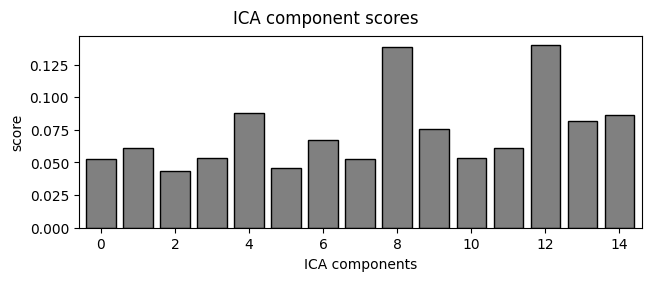

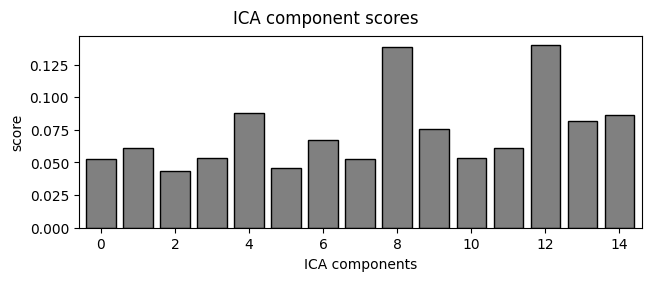

In [15]:
ecg_epochs = mne.preprocessing.create_ecg_epochs(modraw)
ecg_inds, scores = ica.find_bads_ecg(ecg_epochs)
ica.plot_scores(scores) 

In [16]:
len(ecg_inds)

0

In [17]:
ica.exclude = ecg_inds

In [18]:
modraw_clean = ica.apply(modraw.copy())

Applying ICA to Raw instance
    Transforming to ICA space (15 components)
    Zeroing out 0 ICA components
    Projecting back using 20 PCA components


In [19]:
# Normalization

# Access the data as a NumPy array
data, _ = modraw.get_data(return_times=True)

# Standardize the data: (x - mean) / std
data_standardized = (data - np.mean(data, axis=1, keepdims=True)) / np.std(data, axis=1, keepdims=True)

# Update the Raw object with the standardized data
modraw._data = data_standardized

In [20]:
components = ica.get_components()

In [21]:
components.shape

(20, 15)

In [22]:
# Applying bandpass filter
modraw.filter(l_freq=0.5, h_freq=40.0, picks='eeg', method='fir', phase='zero')

# Applying notch filter to remove power line noise

modraw.notch_filter(freqs=60, picks='eeg')

Filtering raw data in 1 contiguous segment
Setting up band-pass filter from 0.5 - 40 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 0.50
- Lower transition bandwidth: 0.50 Hz (-6 dB cutoff frequency: 0.25 Hz)
- Upper passband edge: 40.00 Hz
- Upper transition bandwidth: 10.00 Hz (-6 dB cutoff frequency: 45.00 Hz)
- Filter length: 3301 samples (6.602 s)

Filtering raw data in 1 contiguous segment
Setting up band-stop filter from 59 - 61 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandstop filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 59.35
- Lower transition bandwidth: 0.50 Hz (-6 dB cutoff frequency: 59.10 Hz)
- Upper passband e

<RawEDF | Subject12_1.edf, 21 x 91000 (182.0 s), ~14.6 MiB, data loaded>

In [23]:
csv_path = Path(os.getcwd()).parent.parent / 'data/eegdata' / 'subject-info.csv'

metadata_df = pd.read_csv(csv_path)

In [24]:
metadata_df

,Subject,Age,Gender,Recording year,Number of subtractions,Count quality
0,Subject00,21,F,2011,9.70,0
1,Subject01,18,F,2011,29.35,1
2,Subject02,19,F,2012,12.88,1
3,Subject03,17,F,2010,31.00,1
4,Subject04,17,F,2010,8.60,0
5,Subject05,16,F,2010,20.71,1
6,Subject06,18,M,2011,4.35,0
7,Subject07,18,F,2012,13.38,1
8,Subject08,26,M,2011,18.24,1
9,Subject09,16,F,2010,7.00,0


In [25]:
metadata_df['Count quality'].value_counts()

Count quality
1    26
0    10
Name: count, dtype: int64

In [29]:
import numpy as np
import pandas as pd
import mne
from scipy import signal
from typing import Dict, List, Tuple, Union
import pywt


class EEGFeatureExtractor:
    """Extracts various brainwave features from preprocessed EEG data."""
    
    # Define frequency bands of interest
    BRAINWAVE_BANDS = {
        'delta': (0.5, 4),    # Sleep, deep relaxation
        'theta': (4, 8),      # Drowsiness, meditation, creativity
        'alpha': (8, 13),     # Relaxation, calmness, reflection
        'beta': (13, 30),     # Active thinking, focus, alertness
        'gamma': (30, 45)     # Higher cognitive processing, perception
    }
    
    def __init__(self, sfreq: float = 500.0):
        """
        Initialize the feature extractor.
        
        Args:
            sfreq: Sampling frequency of the EEG data (Hz)
        """
        self.sfreq = sfreq
    
    def extract_features(self, 
                         data: Union[mne.io.Raw, mne.Epochs, np.ndarray]):
        """
        Extract features from EEG data.
        
        Args:
            data: EEG data (MNE Raw/Epochs object or numpy array)
            include_bands: List of frequency bands to include 
                           (default: all bands)
            include_connectivity: Whether to include connectivity features
            include_complexity: Whether to include complexity measures
            
        Returns:
            DataFrame with extracted features
        """
        # Determine which bands to extract
        signals = data.get_data()
        bands = list(self.BRAINWAVE_BANDS.keys())
        
        # Initialize features dictionary
        features = {}
        
        # Extract band power features
        band_powers = self._extract_band_powers(signals, bands)
        features.update(band_powers)
        
        # Extract band power ratios
        power_ratios = self._extract_power_ratios(band_powers)
        features.update(power_ratios)

        # Extract hjorth parameters
        hjorth_params = self._extract_hjorth_parameters(signals)
        features.update(hjorth_params)

        # Extract wavelet features
        wvlt_ratios = self.extract_wavelet_features(signals)
        features.update(wvlt_ratios)
        
        # Extract complexity measures if requested
        # if include_complexity:
        # complexity = self._extract_complexity_measures(signals)
        # features.update(complexity)
        
        # Convert to DataFrame - for scalar values, we need to create a DataFrame with a single row
        df = pd.DataFrame(features, index=[0])
        
        return df
    
    def _extract_band_powers(self, signals: np.ndarray, 
                            include_bands: List[str]) -> Dict:
        """
        Extract power in different frequency bands.
        
        Args:
            signals: EEG signals with shape (channels, samples)
            include_bands: List of frequency bands to include
            
        Returns:
            Dictionary with band power features
        """
        features = {}
        n_channels = signals.shape[0]
        
        for band_name in include_bands:
            if band_name not in self.BRAINWAVE_BANDS:
                continue
                
            fmin, fmax = self.BRAINWAVE_BANDS[band_name]
            
            # Calculate power spectral density
            for ch_idx in range(n_channels):
                # Compute power spectrum
                f, psd = signal.welch(signals[ch_idx], fs=self.sfreq, 
                                     nperseg=min(256, signals.shape[1]//2))
                
                # Find indices corresponding to the frequency band
                idx_band = np.logical_and(f >= fmin, f <= fmax)
                
                # Calculate average power in the band
                power = np.mean(psd[idx_band])
                
                # Store in features dictionary
                feature_name = f"{band_name}_power_ch{ch_idx+1}"
                features[feature_name] = power
                
            # Also compute average across channels
            features[f"{band_name}_power_avg"] = np.mean(
                [features[f"{band_name}_power_ch{ch_idx+1}"] for ch_idx in range(n_channels)]
            )
        
        return features
    
    def _extract_power_ratios(self, band_powers: Dict) -> Dict:
        """
        Calculate ratios between different frequency bands.
        
        Args:
            band_powers: Dictionary with band power features
            
        Returns:
            Dictionary with band power ratio features
        """
        features = {}
        
        # Define interesting ratios
        ratios = [
            ('theta', 'beta'),    # Relaxation vs. focus
            ('alpha', 'beta'),    # Relaxation vs. active thinking
            ('theta', 'alpha'),   # Meditation vs. relaxed alertness
            ('delta', 'beta')     # Deep relaxation vs. active thinking
        ]
        
        # Calculate average band powers across channels
        for numerator, denominator in ratios:
            num_key = f"{numerator}_power_avg"
            denom_key = f"{denominator}_power_avg"
            
            if num_key in band_powers and denom_key in band_powers:
                ratio_name = f"{numerator}_{denominator}_ratio"
                
                # Avoid division by zero
                if band_powers[denom_key] > 0:
                    ratio = band_powers[num_key] / band_powers[denom_key]
                else:
                    ratio = 0
                    
                features[ratio_name] = ratio
        
        return features

    def _extract_hjorth_parameters(self, signals: np.ndarray) -> Dict:
        """
        Extract Hjorth parameters (Activity, Mobility, Complexity) from EEG signals.
        
        Args:
            signals: EEG signals with shape (channels, samples)
        
        Returns:
            Dictionary with Hjorth features
        """
        features = {}
        n_channels = signals.shape[0]

        for ch_idx in range(n_channels):
            signal = signals[ch_idx]
            first_deriv = np.diff(signal)
            second_deriv = np.diff(first_deriv)

            activity = np.var(signal)
            mobility = np.sqrt(np.var(first_deriv) / activity) if activity > 0 else 0
            complexity = (np.sqrt(np.var(second_deriv) / np.var(first_deriv))
                        / mobility) if mobility > 0 and np.var(first_deriv) > 0 else 0

            features[f'hjorth_activity_ch{ch_idx+1}'] = activity
            features[f'hjorth_mobility_ch{ch_idx+1}'] = mobility
            features[f'hjorth_complexity_ch{ch_idx+1}'] = complexity

        # Average across channels
        features['hjorth_activity_avg'] = np.mean([features[f'hjorth_activity_ch{i+1}'] for i in range(n_channels)])
        features['hjorth_mobility_avg'] = np.mean([features[f'hjorth_mobility_ch{i+1}'] for i in range(n_channels)])
        features['hjorth_complexity_avg'] = np.mean([features[f'hjorth_complexity_ch{i+1}'] for i in range(n_channels)])

        return features
    
    def extract_wavelet_features(self, signals: np.ndarray, 
                                wavelet: str = 'db4',
                                level: int = 5) -> Dict:
        """
        Extract wavelet-based features from EEG signals.
        
        Args:
            signals: EEG signals with shape (channels, samples)
            wavelet: Wavelet type
            level: Decomposition level
            
        Returns:
            Dictionary with wavelet features
        """
        features = {}
        n_channels = signals.shape[0]
        
        for ch_idx in range(n_channels):
            signal = signals[ch_idx]
            
            # Perform wavelet decomposition
            coeffs = pywt.wavedec(signal, wavelet, level=level)
            
            # Extract features from each coefficient level
            for i, coef in enumerate(coeffs):
                # Calculate energy
                energy = np.sum(coef**2) / len(coef)
                features[f"wavelet_energy_ch{ch_idx+1}_level{i}"] = energy
                
                # Calculate entropy
                if np.any(coef):
                    p = coef**2 / np.sum(coef**2)
                    p = p[p > 0]  # Avoid log(0)
                    entropy = -np.sum(p * np.log2(p))
                else:
                    entropy = 0
                features[f"wavelet_entropy_ch{ch_idx+1}_level{i}"] = entropy
        
        return features

In [30]:
def apply_preprocessing(raw: mne.io.Raw):

    # # Applying bandpass filter
    # modraw.filter(l_freq=0.5, h_freq=40.0, picks='eeg', method='fir', phase='zero')

    # # Applying notch filter to remove power line noise

    # modraw.notch_filter(freqs=60, picks='eeg')

    # # Perform independent component analysis to remove artifacts (if any)
    raw.set_channel_types({'ECG ECG': 'ecg'})
    
    ica = mne.preprocessing.ICA(
    n_components=15,
    random_state=42,
    method='fastica', verbose='ERROR'
    )

    ica.fit(raw)

    ecg_epochs = mne.preprocessing.create_ecg_epochs(raw, verbose='ERROR')
    ecg_inds, scores = ica.find_bads_ecg(ecg_epochs, verbose='ERROR')
    # ica.plot_scores(scores) 
    
    ica.exclude = ecg_inds
    ica.apply(raw)

    modraw = ica.apply(raw.copy(), verbose='ERROR')

    modraw.drop_channels(['ECG ECG'])

    # Access the data as a NumPy array
    # data, _ = modraw.get_data(return_times=True)

    # # Standardize the data: (x - mean) / std
    # data_standardized = (data - np.mean(data, axis=1, keepdims=True)) / np.std(data, axis=1, keepdims=True)

    # # Update the Raw object with the standardized data
    # modraw._data = data_standardized

    return modraw
    

In [31]:
dat = processed_eeg_extract['Subject00_1'].copy()

In [32]:
ext = EEGFeatureExtractor()

feat_dat = ext.extract_features(dat)

In [33]:
feat_dat

,delta_power_ch1,delta_power_ch2,delta_power_ch3,delta_power_ch4,delta_power_ch5,delta_power_ch6,delta_power_ch7,delta_power_ch8,delta_power_ch9,delta_power_ch10,...,wavelet_energy_ch21_level1,wavelet_entropy_ch21_level1,wavelet_energy_ch21_level2,wavelet_entropy_ch21_level2,wavelet_energy_ch21_level3,wavelet_entropy_ch21_level3,wavelet_energy_ch21_level4,wavelet_entropy_ch21_level4,wavelet_energy_ch21_level5,wavelet_entropy_ch21_level5
0,4.222842e-12,6.503660e-12,7.045895e-12,7.726862e-12,1.249790e-11,8.904972e-12,8.890072e-12,5.936458e-12,8.959183e-12,7.458552e-12,...,1.324070e-07,9.022605,2.984569e-08,8.857585,1.289166e-09,9.717926,1.100183e-11,10.931136,2.455829e-13,3.649624


In [34]:
mne.set_log_level('WARNING')  # Options: 'DEBUG', 'INFO', 'WARNING', 'ERROR', 'CRITICAL'

# Prepare data from all subjects
all_features = []

for subject_id in metadata_df.Subject.values:

    # eegmat data: 1 = baseline, 2 = arithmetic

    baseline_file_path = Path(os.getcwd()).parent.parent / 'data/eegdata' / f'{subject_id}_1.edf'
    arithmetic_file_path = Path(os.getcwd()).parent.parent / 'data/eegdata' / f'{subject_id}_2.edf'

    baseline_raw = mne.io.read_raw_edf(baseline_file_path, preload=True, verbose=False)
    arithmetic_raw = mne.io.read_raw_edf(arithmetic_file_path, preload=True, verbose=False)
    
    # Preprocess the data
    arithmetic_processed = apply_preprocessing(arithmetic_raw)
    baseline_processed = apply_preprocessing(baseline_raw)
    
    # Extract features
    feature_extractor = EEGFeatureExtractor(sfreq=arithmetic_raw.info['sfreq'])

    baseline_features = feature_extractor.extract_features(baseline_processed)
    baseline_features['label'] = 0  # Relaxed (baseline)
    baseline_features['subject_id'] = subject_id

    arithmetic_features = feature_extractor.extract_features(arithmetic_processed)
    arithmetic_features['label'] = 1  # Focused (mental arithmetic)
    arithmetic_features['subject_id'] = subject_id
    
    # Combine features for this subject
    subject_features = pd.concat([arithmetic_features, baseline_features], ignore_index=True)
    all_features.append(subject_features)

    print(f'Subject {subject_id} processed!')
        
all_features_df = pd.concat(all_features, ignore_index=True)

print(f"Total dataset: {len(all_features_df)} samples, {all_features_df.shape[1]-2} features")

Subject Subject00 processed!


C:\Users\Audit\AppData\Local\Temp\ipykernel_149460\3311919681.py:19: RuntimeWarning: The data has not been high-pass filtered. For good ICA performance, it should be high-pass filtered (e.g., with a 1.0 Hz lower bound) before fitting ICA.
  ica.fit(raw)
C:\Users\Audit\AppData\Local\Temp\ipykernel_149460\3311919681.py:19: RuntimeWarning: The data has not been high-pass filtered. For good ICA performance, it should be high-pass filtered (e.g., with a 1.0 Hz lower bound) before fitting ICA.
  ica.fit(raw)


Subject Subject01 processed!


C:\Users\Audit\AppData\Local\Temp\ipykernel_149460\3311919681.py:19: RuntimeWarning: The data has not been high-pass filtered. For good ICA performance, it should be high-pass filtered (e.g., with a 1.0 Hz lower bound) before fitting ICA.
  ica.fit(raw)
C:\Users\Audit\AppData\Local\Temp\ipykernel_149460\3311919681.py:19: RuntimeWarning: The data has not been high-pass filtered. For good ICA performance, it should be high-pass filtered (e.g., with a 1.0 Hz lower bound) before fitting ICA.
  ica.fit(raw)


Subject Subject02 processed!
Subject Subject03 processed!


C:\Users\Audit\AppData\Local\Temp\ipykernel_149460\3311919681.py:19: RuntimeWarning: The data has not been high-pass filtered. For good ICA performance, it should be high-pass filtered (e.g., with a 1.0 Hz lower bound) before fitting ICA.
  ica.fit(raw)
C:\Users\Audit\AppData\Local\Temp\ipykernel_149460\3311919681.py:19: RuntimeWarning: The data has not been high-pass filtered. For good ICA performance, it should be high-pass filtered (e.g., with a 1.0 Hz lower bound) before fitting ICA.
  ica.fit(raw)


Subject Subject04 processed!


C:\Users\Audit\AppData\Local\Temp\ipykernel_149460\3311919681.py:19: RuntimeWarning: The data has not been high-pass filtered. For good ICA performance, it should be high-pass filtered (e.g., with a 1.0 Hz lower bound) before fitting ICA.
  ica.fit(raw)
C:\Users\Audit\AppData\Local\Temp\ipykernel_149460\3311919681.py:19: RuntimeWarning: The data has not been high-pass filtered. For good ICA performance, it should be high-pass filtered (e.g., with a 1.0 Hz lower bound) before fitting ICA.
  ica.fit(raw)


Subject Subject05 processed!


C:\Users\Audit\AppData\Local\Temp\ipykernel_149460\3311919681.py:19: RuntimeWarning: The data has not been high-pass filtered. For good ICA performance, it should be high-pass filtered (e.g., with a 1.0 Hz lower bound) before fitting ICA.
  ica.fit(raw)
c:\Users\Audit\.conda\envs\dl\Lib\site-packages\sklearn\decomposition\_fastica.py:127: ConvergenceWarning: FastICA did not converge. Consider increasing tolerance or the maximum number of iterations.
  warnings.warn(
C:\Users\Audit\AppData\Local\Temp\ipykernel_149460\3311919681.py:19: RuntimeWarning: The data has not been high-pass filtered. For good ICA performance, it should be high-pass filtered (e.g., with a 1.0 Hz lower bound) before fitting ICA.
  ica.fit(raw)


Subject Subject06 processed!


C:\Users\Audit\AppData\Local\Temp\ipykernel_149460\3311919681.py:19: RuntimeWarning: The data has not been high-pass filtered. For good ICA performance, it should be high-pass filtered (e.g., with a 1.0 Hz lower bound) before fitting ICA.
  ica.fit(raw)
C:\Users\Audit\AppData\Local\Temp\ipykernel_149460\3311919681.py:19: RuntimeWarning: The data has not been high-pass filtered. For good ICA performance, it should be high-pass filtered (e.g., with a 1.0 Hz lower bound) before fitting ICA.
  ica.fit(raw)


Subject Subject07 processed!


C:\Users\Audit\AppData\Local\Temp\ipykernel_149460\3311919681.py:19: RuntimeWarning: The data has not been high-pass filtered. For good ICA performance, it should be high-pass filtered (e.g., with a 1.0 Hz lower bound) before fitting ICA.
  ica.fit(raw)


Subject Subject08 processed!


C:\Users\Audit\AppData\Local\Temp\ipykernel_149460\3311919681.py:19: RuntimeWarning: The data has not been high-pass filtered. For good ICA performance, it should be high-pass filtered (e.g., with a 1.0 Hz lower bound) before fitting ICA.
  ica.fit(raw)
C:\Users\Audit\AppData\Local\Temp\ipykernel_149460\3311919681.py:19: RuntimeWarning: The data has not been high-pass filtered. For good ICA performance, it should be high-pass filtered (e.g., with a 1.0 Hz lower bound) before fitting ICA.
  ica.fit(raw)


Subject Subject09 processed!


C:\Users\Audit\AppData\Local\Temp\ipykernel_149460\3311919681.py:19: RuntimeWarning: The data has not been high-pass filtered. For good ICA performance, it should be high-pass filtered (e.g., with a 1.0 Hz lower bound) before fitting ICA.
  ica.fit(raw)


Subject Subject10 processed!


C:\Users\Audit\AppData\Local\Temp\ipykernel_149460\3311919681.py:19: RuntimeWarning: The data has not been high-pass filtered. For good ICA performance, it should be high-pass filtered (e.g., with a 1.0 Hz lower bound) before fitting ICA.
  ica.fit(raw)


Subject Subject11 processed!


C:\Users\Audit\AppData\Local\Temp\ipykernel_149460\3311919681.py:19: RuntimeWarning: The data has not been high-pass filtered. For good ICA performance, it should be high-pass filtered (e.g., with a 1.0 Hz lower bound) before fitting ICA.
  ica.fit(raw)
C:\Users\Audit\AppData\Local\Temp\ipykernel_149460\3311919681.py:19: RuntimeWarning: The data has not been high-pass filtered. For good ICA performance, it should be high-pass filtered (e.g., with a 1.0 Hz lower bound) before fitting ICA.
  ica.fit(raw)


Subject Subject12 processed!


C:\Users\Audit\AppData\Local\Temp\ipykernel_149460\3311919681.py:19: RuntimeWarning: The data has not been high-pass filtered. For good ICA performance, it should be high-pass filtered (e.g., with a 1.0 Hz lower bound) before fitting ICA.
  ica.fit(raw)


Subject Subject13 processed!


C:\Users\Audit\AppData\Local\Temp\ipykernel_149460\3311919681.py:19: RuntimeWarning: The data has not been high-pass filtered. For good ICA performance, it should be high-pass filtered (e.g., with a 1.0 Hz lower bound) before fitting ICA.
  ica.fit(raw)
C:\Users\Audit\AppData\Local\Temp\ipykernel_149460\3311919681.py:19: RuntimeWarning: The data has not been high-pass filtered. For good ICA performance, it should be high-pass filtered (e.g., with a 1.0 Hz lower bound) before fitting ICA.
  ica.fit(raw)


Subject Subject14 processed!


C:\Users\Audit\AppData\Local\Temp\ipykernel_149460\3311919681.py:19: RuntimeWarning: The data has not been high-pass filtered. For good ICA performance, it should be high-pass filtered (e.g., with a 1.0 Hz lower bound) before fitting ICA.
  ica.fit(raw)
C:\Users\Audit\AppData\Local\Temp\ipykernel_149460\3311919681.py:19: RuntimeWarning: The data has not been high-pass filtered. For good ICA performance, it should be high-pass filtered (e.g., with a 1.0 Hz lower bound) before fitting ICA.
  ica.fit(raw)


Subject Subject15 processed!


C:\Users\Audit\AppData\Local\Temp\ipykernel_149460\3311919681.py:19: RuntimeWarning: The data has not been high-pass filtered. For good ICA performance, it should be high-pass filtered (e.g., with a 1.0 Hz lower bound) before fitting ICA.
  ica.fit(raw)


Subject Subject16 processed!


C:\Users\Audit\AppData\Local\Temp\ipykernel_149460\3311919681.py:19: RuntimeWarning: The data has not been high-pass filtered. For good ICA performance, it should be high-pass filtered (e.g., with a 1.0 Hz lower bound) before fitting ICA.
  ica.fit(raw)


Subject Subject17 processed!


C:\Users\Audit\AppData\Local\Temp\ipykernel_149460\3311919681.py:19: RuntimeWarning: The data has not been high-pass filtered. For good ICA performance, it should be high-pass filtered (e.g., with a 1.0 Hz lower bound) before fitting ICA.
  ica.fit(raw)
C:\Users\Audit\AppData\Local\Temp\ipykernel_149460\3311919681.py:19: RuntimeWarning: The data has not been high-pass filtered. For good ICA performance, it should be high-pass filtered (e.g., with a 1.0 Hz lower bound) before fitting ICA.
  ica.fit(raw)


Subject Subject18 processed!


C:\Users\Audit\AppData\Local\Temp\ipykernel_149460\3311919681.py:19: RuntimeWarning: The data has not been high-pass filtered. For good ICA performance, it should be high-pass filtered (e.g., with a 1.0 Hz lower bound) before fitting ICA.
  ica.fit(raw)
C:\Users\Audit\AppData\Local\Temp\ipykernel_149460\3311919681.py:19: RuntimeWarning: The data has not been high-pass filtered. For good ICA performance, it should be high-pass filtered (e.g., with a 1.0 Hz lower bound) before fitting ICA.
  ica.fit(raw)


Subject Subject19 processed!


C:\Users\Audit\AppData\Local\Temp\ipykernel_149460\3311919681.py:19: RuntimeWarning: The data has not been high-pass filtered. For good ICA performance, it should be high-pass filtered (e.g., with a 1.0 Hz lower bound) before fitting ICA.
  ica.fit(raw)
C:\Users\Audit\AppData\Local\Temp\ipykernel_149460\3311919681.py:19: RuntimeWarning: The data has not been high-pass filtered. For good ICA performance, it should be high-pass filtered (e.g., with a 1.0 Hz lower bound) before fitting ICA.
  ica.fit(raw)


Subject Subject20 processed!
Subject Subject21 processed!


C:\Users\Audit\AppData\Local\Temp\ipykernel_149460\3311919681.py:19: RuntimeWarning: The data has not been high-pass filtered. For good ICA performance, it should be high-pass filtered (e.g., with a 1.0 Hz lower bound) before fitting ICA.
  ica.fit(raw)


Subject Subject22 processed!
Subject Subject23 processed!


C:\Users\Audit\AppData\Local\Temp\ipykernel_149460\3311919681.py:19: RuntimeWarning: The data has not been high-pass filtered. For good ICA performance, it should be high-pass filtered (e.g., with a 1.0 Hz lower bound) before fitting ICA.
  ica.fit(raw)
C:\Users\Audit\AppData\Local\Temp\ipykernel_149460\3311919681.py:19: RuntimeWarning: The data has not been high-pass filtered. For good ICA performance, it should be high-pass filtered (e.g., with a 1.0 Hz lower bound) before fitting ICA.
  ica.fit(raw)


Subject Subject24 processed!
Subject Subject25 processed!
Subject Subject26 processed!


C:\Users\Audit\AppData\Local\Temp\ipykernel_149460\3311919681.py:19: RuntimeWarning: The data has not been high-pass filtered. For good ICA performance, it should be high-pass filtered (e.g., with a 1.0 Hz lower bound) before fitting ICA.
  ica.fit(raw)
C:\Users\Audit\AppData\Local\Temp\ipykernel_149460\3311919681.py:19: RuntimeWarning: The data has not been high-pass filtered. For good ICA performance, it should be high-pass filtered (e.g., with a 1.0 Hz lower bound) before fitting ICA.
  ica.fit(raw)


Subject Subject27 processed!


C:\Users\Audit\AppData\Local\Temp\ipykernel_149460\3311919681.py:19: RuntimeWarning: The data has not been high-pass filtered. For good ICA performance, it should be high-pass filtered (e.g., with a 1.0 Hz lower bound) before fitting ICA.
  ica.fit(raw)
C:\Users\Audit\AppData\Local\Temp\ipykernel_149460\3311919681.py:19: RuntimeWarning: The data has not been high-pass filtered. For good ICA performance, it should be high-pass filtered (e.g., with a 1.0 Hz lower bound) before fitting ICA.
  ica.fit(raw)


Subject Subject28 processed!
Subject Subject29 processed!


C:\Users\Audit\AppData\Local\Temp\ipykernel_149460\3311919681.py:19: RuntimeWarning: The data has not been high-pass filtered. For good ICA performance, it should be high-pass filtered (e.g., with a 1.0 Hz lower bound) before fitting ICA.
  ica.fit(raw)
C:\Users\Audit\AppData\Local\Temp\ipykernel_149460\3311919681.py:19: RuntimeWarning: The data has not been high-pass filtered. For good ICA performance, it should be high-pass filtered (e.g., with a 1.0 Hz lower bound) before fitting ICA.
  ica.fit(raw)


Subject Subject30 processed!


C:\Users\Audit\AppData\Local\Temp\ipykernel_149460\3311919681.py:19: RuntimeWarning: The data has not been high-pass filtered. For good ICA performance, it should be high-pass filtered (e.g., with a 1.0 Hz lower bound) before fitting ICA.
  ica.fit(raw)


Subject Subject31 processed!


C:\Users\Audit\AppData\Local\Temp\ipykernel_149460\3311919681.py:19: RuntimeWarning: The data has not been high-pass filtered. For good ICA performance, it should be high-pass filtered (e.g., with a 1.0 Hz lower bound) before fitting ICA.
  ica.fit(raw)


Subject Subject32 processed!
Subject Subject33 processed!


C:\Users\Audit\AppData\Local\Temp\ipykernel_149460\3311919681.py:19: RuntimeWarning: The data has not been high-pass filtered. For good ICA performance, it should be high-pass filtered (e.g., with a 1.0 Hz lower bound) before fitting ICA.
  ica.fit(raw)
C:\Users\Audit\AppData\Local\Temp\ipykernel_149460\3311919681.py:19: RuntimeWarning: The data has not been high-pass filtered. For good ICA performance, it should be high-pass filtered (e.g., with a 1.0 Hz lower bound) before fitting ICA.
  ica.fit(raw)


Subject Subject34 processed!


C:\Users\Audit\AppData\Local\Temp\ipykernel_149460\3311919681.py:19: RuntimeWarning: The data has not been high-pass filtered. For good ICA performance, it should be high-pass filtered (e.g., with a 1.0 Hz lower bound) before fitting ICA.
  ica.fit(raw)
C:\Users\Audit\AppData\Local\Temp\ipykernel_149460\3311919681.py:19: RuntimeWarning: The data has not been high-pass filtered. For good ICA performance, it should be high-pass filtered (e.g., with a 1.0 Hz lower bound) before fitting ICA.
  ica.fit(raw)


Subject Subject35 processed!
Total dataset: 72 samples, 412 features


In [35]:
all_features_df['group'] = all_features_df.apply(lambda row: 'G' if int(metadata_df[ metadata_df['Subject'] == row['subject_id']]['Count quality'].values[0]) is 1 else 'B', axis= 1)

<>:1: SyntaxWarning: "is" with 'int' literal. Did you mean "=="?
C:\Users\Audit\AppData\Local\Temp\ipykernel_149460\1696147159.py:1: SyntaxWarning: "is" with 'int' literal. Did you mean "=="?
  all_features_df['group'] = all_features_df.apply(lambda row: 'G' if int(metadata_df[ metadata_df['Subject'] == row['subject_id']]['Count quality'].values[0]) is 1 else 'B', axis= 1)


In [36]:
all_features_df

,delta_power_ch1,delta_power_ch2,delta_power_ch3,delta_power_ch4,delta_power_ch5,delta_power_ch6,delta_power_ch7,delta_power_ch8,delta_power_ch9,delta_power_ch10,...,wavelet_entropy_ch20_level2,wavelet_energy_ch20_level3,wavelet_entropy_ch20_level3,wavelet_energy_ch20_level4,wavelet_entropy_ch20_level4,wavelet_energy_ch20_level5,wavelet_entropy_ch20_level5,label,subject_id,group
0,1.725174e-11,9.029676e-12,1.261337e-11,9.539786e-12,1.016186e-11,1.010765e-11,8.047932e-12,1.461013e-11,9.792607e-12,8.663428e-12,...,9.650531,1.744848e-11,10.364758,3.714939e-13,11.206369,2.193018e-15,10.030254,1,Subject00,B
1,4.182356e-12,6.272768e-12,7.184455e-12,7.640796e-12,1.191885e-11,8.544845e-12,8.552047e-12,6.090970e-12,8.615565e-12,7.348278e-12,...,11.177664,1.568055e-12,12.277431,1.902976e-14,13.276216,1.058351e-16,10.726541,0,Subject00,B
2,1.205710e-11,5.682826e-12,9.456776e-12,8.818778e-12,1.588308e-11,1.784466e-11,8.623565e-12,8.635721e-12,9.423500e-12,1.048531e-11,...,9.647204,1.733441e-11,10.426310,7.533099e-13,11.280950,6.651178e-15,10.633434,1,Subject01,G
3,3.140093e-12,3.589706e-12,5.903520e-12,7.289969e-12,2.660366e-12,5.224892e-12,5.114115e-12,6.142002e-12,7.146590e-12,7.019636e-12,...,10.742694,4.794081e-12,10.551747,2.481266e-13,10.543754,1.879798e-15,11.222215,0,Subject01,G
4,3.718112e-12,1.126030e-11,5.099439e-12,5.781680e-12,3.858842e-12,8.515053e-12,5.748654e-12,6.169256e-12,8.299339e-12,8.549375e-12,...,9.582834,1.881824e-11,10.788460,7.737453e-13,11.703615,7.115742e-15,10.619211,1,Subject02,G
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
67,3.162819e-12,3.367813e-12,2.638430e-12,1.306422e-12,6.017704e-12,2.429026e-12,1.592783e-12,1.788047e-12,2.810957e-12,1.853084e-12,...,11.403273,5.196267e-12,12.300545,8.831527e-14,13.095688,4.527892e-16,12.149412,0,Subject33,G
68,7.824828e-12,5.214063e-12,8.411943e-12,7.585081e-12,3.533064e-12,1.650787e-11,4.930618e-12,5.466581e-12,7.800166e-12,6.532623e-12,...,9.740945,6.731406e-12,10.710752,1.808642e-13,11.673520,1.306713e-15,11.141845,1,Subject34,G
69,4.935620e-12,5.741902e-12,7.390510e-12,6.805590e-12,4.837615e-12,6.642106e-12,6.961402e-12,5.019887e-12,9.958404e-12,8.982093e-12,...,10.999874,1.620737e-11,11.692744,5.771500e-13,12.628693,5.363919e-15,10.830919,0,Subject34,G
70,8.915011e-12,4.054711e-12,5.384128e-12,7.402208e-12,4.823530e-12,5.248096e-12,6.817450e-12,6.599852e-12,6.397065e-12,7.023197e-12,...,9.772986,1.030204e-11,10.717026,5.628612e-13,11.585765,2.541247e-13,11.857544,1,Subject35,G


In [ ]:
from sklearn.ensemble import RandomForestClassifier, ExtraTreesClassifier
from sklearn.svm import SVC
from sklearn.neural_network import MLPClassifier
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import GridSearchCV, train_test_split
from sklearn.metrics import accuracy_score, balanced_accuracy_score, f1_score, confusion_matrix


MODELS = {
    "ET": {
        "function": ExtraTreesClassifier(),
        "param_grid": [
            {
                "ET__n_estimators": [2, 5, 10, 20],
                "ET__criterion": ["gini", "entropy", "log_loss"],
                "ET__max_depth": [i for i in range (2,16)], #, 15, 20, 25
                "ET__max_features": [0.1, 0.2, "sqrt", "log2"],
            }
        ],
    },
    "RF": {
        "function": RandomForestClassifier(),
        "param_grid": [
            {
                "RF__n_estimators": [2, 5, 10, 20],
                "RF__criterion": ["gini", "entropy", "log_loss"],
                "RF__max_depth": [i for i in range (2,16)], #, 15, 20, 25
                "RF__max_features": [0.1, 0.2, "sqrt", "log2"],
            }
        ],
    },
    "SVM": {
        "function": SVC(),
        "param_grid": [
            {"SVM__kernel": ["poly"], "SVM__degree": [2, 3, 4, 5, 6, 7, 8]}, #, 6, 7, 8, 9, 10, 15
            {"SVM__kernel": ["linear", "rbf", "sigmoid"]},
        ],
    },
    "MLP": {
        "function": MLPClassifier(),
        "param_grid": [{
                'MLP__hidden_layer_sizes': [(10,10), (5,10,5), (10,50,10)],
                'MLP__activation': ['relu'],
                'MLP__solver': ['sgd', 'adam'],
                'MLP__learning_rate_init': [0.1, 0.01, 0.001],
                'MLP__learning_rate': ['constant', 'adaptive'],
                'MLP__max_iter': [100,250, 500]
            }], # , 9, 11, 13, 15
    }
}

def calculate_metrics(y_true: np.ndarray, y_pred: np.ndarray):
    """
    Calculate performance metrics.
    
    Args:
        y_true: True labels
        y_pred: Predicted labels
        
    Returns:
        Dictionary with metrics
    """
    return {
        'accuracy' : accuracy_score(y_true, y_pred),
        'balanced accuracy': balanced_accuracy_score(y_true, y_pred),
        'f1': f1_score(y_true, y_pred, average='binary')
    }

def train_and_cross_validate(X, Y, cl_name, cv_folds, seed):
     
    X_train, X_val, y_train, y_val = train_test_split(
                    X, Y, test_size=0.2, random_state=seed, stratify=Y
                )
    
    pipe = Pipeline([
        ('sc', StandardScaler()),
        (cl_name, MODELS[cl_name]['function'])
    ])

    param_grid = MODELS[cl_name]['param_grid']
    
    grid_search = GridSearchCV(
                pipe, param_grid, cv=cv_folds, 
                scoring='f1', n_jobs=-1, verbose=1
            )
            
    grid_search.fit(X_train, y_train)
    best_model = grid_search.best_estimator_

    # Evaluate on validation set
    y_pred = best_model.predict(X_val)

    metrics = calculate_metrics(y_val, y_pred)
    metrics['model'] = cl_name
    metrics['split'] = 'val'

    metrics_df = pd.DataFrame(metrics, index=[0])
    
    return metrics_df, best_model

In [ ]:
X = all_features_df[[ x for x in all_features_df.columns if x not in ['label',	'subject_id', 'group']]]
Y = all_features_df['label']

def initiate_cross_validation(X, Y, seed, cv_folds = 5):

    X_train, X_test, y_train, y_test = train_test_split(
                        X, Y, test_size=0.3, random_state=seed, stratify=Y
                    )

    all_results_list = []

    for name, items in MODELS.items():

        print(f"Model: {name} ")

        # Standard scaler ensures that all the features are in the same range (which are key for regression & distance based algorithms)
        
        val_df, best_model = train_and_cross_validate(X_train, y_train, name, cv_folds)

        y_pred = best_model.predict(X_test)

        test_metrics = calculate_metrics(y_pred, y_test)
        test_metrics['model'] = name
        test_metrics['split'] = 'test'

        test_df = pd.DataFrame(test_metrics, index=[0])
        
        results = pd.concat([val_df, test_df], ignore_index=True)
        all_results_list.append(results)

        print(f'Train & evalutation completed for {name}!')
            
    all_results_df = pd.concat(all_results_list, ignore_index=True)

    return all_results_df

Model: ET 
Fitting 5 folds for each of 672 candidates, totalling 3360 fits
Train & evalutation completed for ET!
Model: RF 
Fitting 5 folds for each of 672 candidates, totalling 3360 fits
Train & evalutation completed for RF!
Model: SVM 
Fitting 5 folds for each of 10 candidates, totalling 50 fits
Train & evalutation completed for SVM!
Model: MLP 
Fitting 5 folds for each of 108 candidates, totalling 540 fits
Train & evalutation completed for MLP!


In [39]:
all_results_df

,accuracy,balanced accuracy,f1,model,split
0,1.000000,1.000000,1.000000,ET,val
1,0.954545,0.958333,0.956522,ET,test
2,1.000000,1.000000,1.000000,RF,val
3,1.000000,1.000000,1.000000,RF,test
4,1.000000,1.000000,1.000000,SVM,val
5,0.954545,0.958333,0.956522,SVM,test
6,1.000000,1.000000,1.000000,MLP,val
7,0.954545,0.958333,0.956522,MLP,test


In [40]:
# Shuffle the data
# all_features_df = all_features_df.sample(frac=1, random_state=42).reset_index(drop=True)

# # Split features and labels
# X = all_features_df.drop(['label', 'subject_id'], axis=1)
# y = all_features_df['label']

# # Initialize and train classifier
# classifier = MentalStateClassifier(model_type=model_type, random_state=42)

# # Train and evaluate the model
# metrics = classifier.train_and_evaluate(X, y, test_size=0.3)
# logger.info(f"Model performance: {metrics}")

# # Save the model
# model_path = os.path.join(models_dir, "mental_state_classifier.joblib")